# Lab Project: Deconstructing the Transformer

Related video: https://www.youtube.com/watch?v=kCc8FmEb1nY

**"Attention is All You Need" – From Scratch**

- **Duration:** 2 Weeks
   
- **Tools:** Python, PyTorch (recommended) or TensorFlow/JAX
   
- **Dataset:** ["Tiny Shakespeare"](https://huggingface.co/datasets/karpathy/tiny_shakespeare) (Character-level text generation)
   


## 1. Project Overview

The goal of this lab is not to use a pre-built library like Hugging Face `transformers` to fine-tune a model. Instead, you will implement the Transformer architecture **layer-by-layer** using basic tensor operations.

By the end of this assignment, you will have a working **Decoder-Only Transformer** (a mini-GPT) capable of generating Shakespearean-style text. You will understand the exact flow of gradients through Self-Attention, Layer Normalization, and Residual Connections.


In [319]:
import requests
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
import time
from datetime import datetime
from pathlib import Path
import pickle

In [277]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 32
block_size = 128
max_iters = 5000
eval_interval = 500
eval_iters = 200
learning_rate = 3e-4
n_embd = 384
n_head = 6
n_layer = 4
dropout = 0.2

In [276]:
@torch.no_grad()
def estimate_loss():
    out={}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return(out)

## 2. The Dataset & Preprocessing

We will use the "Tiny Shakespeare" dataset. It is small, trains quickly on a CPU/low-end GPU, and allows for immediate visual verification (i.e., does the output look like English?).

**Task 0: Setup**

1. Download `input.txt` (Tiny Shakespeare).
   
2. Create a tokenizer: Build a dictionary mapping unique characters to integers (encoding) and integers back to characters (decoding).
   
3. Create a PyTorch `Dataset` or data loader that serves batches of context blocks (e.g., block size of 32 or 64 characters).


In [231]:
input_file = 'input.txt'
file_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

print(f'Downloading file {input_file} from {file_url}...')
with open(input_file,'w') as f:
    f.write(requests.get(file_url).text)

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [232]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f'Total number of symbols : {len(chars)}')
print(chars)

Total number of symbols : 65
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [233]:
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for i,s in enumerate(chars)}

encode = lambda s: [stoi[x] for x in s]
decode = lambda i: ''.join([itos[x] for x in i])

print(stoi,'\n',itos)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64} 
 {0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i

In [234]:
torch.manual_seed(1337)

def get_batch(split):
    data = train_data if split=='train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y= x.to(device), y.to(device)
    return (x,y)


## 3. Implementation Milestones

You must implement the architecture in an object-oriented fashion. Do not use `torch.nn.Transformer` or `torch.nn.MultiheadAttention`. You must build these classes yourself using `torch.nn.Linear`, `torch.matmul`, etc.

### Part I: Positional Embeddings

Transformers process tokens in parallel, meaning they have no inherent sense of order. You must inject this information.

- **Requirement:** Implement the sinusoidal positional encoding as described in the original paper _Attention is All You Need_.
   
- Formula:
   
    $$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{model}})$$
   
    $$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{model}})$$
   
- **Deliverable:** A class `PositionalEncoding(d_model, max_len)` and a plot visualizing the embeddings (heatmap).

In [344]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        T = x.shape[1]
        return x + self.pe[:T, :]

    def plot_heatmap(self, length=100):
        plt.figure(figsize=(16,5))
        pos_embed = copy.deepcopy(self.pe[:length, :])
        plt.imshow(pos_embed.cpu().numpy(), cmap='viridis')
        plt.title('Sinusoidal Positional Embeddings')
        plt.xlabel('Embedding Dimension')
        plt.ylabel('Position (Time Step)')
        plt.colorbar()
        plt.show()

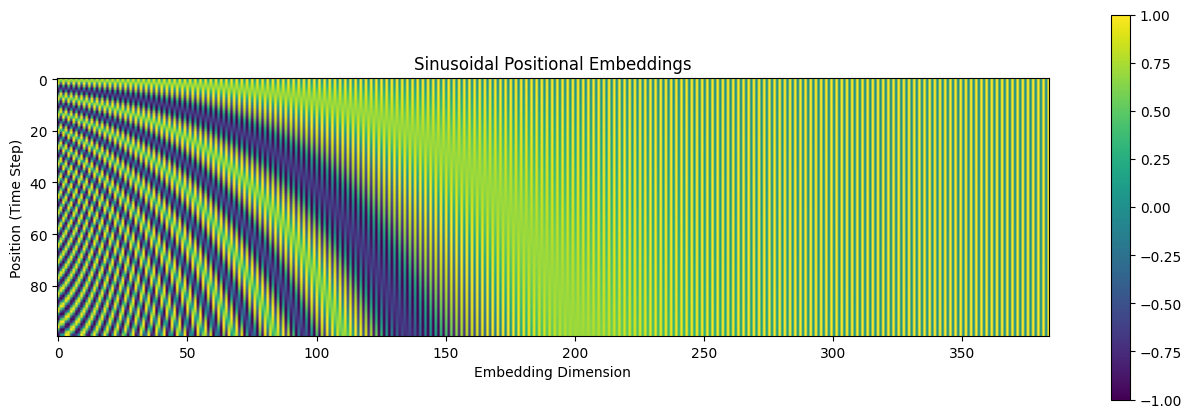

In [345]:
position_embedding_table = PositionalEncoding(n_embd, max_len=block_size)
position_embedding_table.plot_heatmap()

### Part II: Scaled Dot-Product Attention (The Core)

This is the mathematical engine of the Transformer.

- Requirement: Implement a function that takes Query ($Q$), Key ($K$), and Value ($V$) matrices and computes:
   
    $$Attention(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$
   
- **Critical Detail:** You must implement a **Mask**. Since this is a decoder-only model for text generation, the model cannot "see the future." You must apply a lower-triangular mask (setting upper values to $-\infty$) before the softmax so that position $t$ can only attend to positions $0$ through $t$.


In [236]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)

        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        v = self.value(x)
        out = wei @ v
        return out

### Part III: Multi-Head Attention (MHA)

Single-head attention captures one type of relationship. MHA allows the model to focus on different positions jointly from different representation subspaces.

- **Requirement:** Create a `MultiHeadAttention` class.
   
    1. Linear projections for $Q$, $K$, and $V$.
       
    2. Split the heads (reshape the tensors).
       
    3. Apply Scaled Dot-Product Attention (from Part II).
       
    4. Concatenate heads and apply a final linear projection.
       
- **Code Hint:** Be careful with tensor shapes.
   
    - Input: `(Batch, Time, Channels)`
       
    - Reshape to: `(Batch, Time, Heads, Head_Dim)`
       
    - Transpose for matmul: `(Batch, Heads, Time, Head_Dim)`


In [237]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

### Part IV: The Transformer Block

Assemble the components into a repeatable layer.

- **Requirement:** Create a `Block` class containing:
   
    1. **Layer Normalization:** Applied _before_ the sub-layer (Pre-Norm formulation is generally more stable than Post-Norm).
       
    2. **Multi-Head Attention:** Your class from Part III.
       
    3. **Feed-Forward Network:** A simple MLP expanding the dimension by 4x (e.g., `d_model` -> `4*d_model` -> `d_model`) with ReLU or GeLU activation.
       
    4. **Residual Connections:** $x + Sublayer(Norm(x))$.

In [238]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return(self.net(x))

In [239]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return(x)

### Helper functions

In [313]:
def generate_training_plots(train_losses, val_losses, iterations, file_name=None):    
    plt.figure(figsize=(16,9))
    plt.suptitle('Performance metrics')
    color = "tab:red"

    plt.ylabel("Loss", color=color)
    plt.plot(train_losses, color=color, label='Train accuracy')
    plt.plot(val_losses, color='tab:green', label='Validation accuracy')

    plt.xticks(range(len(iterations)),iterations)
    plt.tick_params(axis='y', labelcolor=color)
    plt.legend()
    
    plt.tight_layout()

    if file_name is not None:
        plt.savefig(file_name)
    
    plt.show()

## 4. Assembly and Training

### The Model

Create a `GPTLanguageModel` class that stacks:

1. Token Embeddings + Positional Encodings.
   
2. $N$ layers of your `Block` (Try $N=4$ to $6$).
   
3. Final Layer Norm.
   
4. Final Linear Head (projecting to vocabulary size).

In [263]:
class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        #self.position_embedding_table = nn.Embedding(block_size, n_embd)

        self.position_embedding_table = PositionalEncoding(n_embd, max_len=block_size)
        
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        x = self.position_embedding_table(tok_emb) #torch.arange(T, device=device)) # (T,C)
        #x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)        
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focs only on the last time step
            logits = logits[:, -1, :] # becomes (B,C)
            # apply softmax to the get probabilities
            probs = F.softmax(logits, dim=-1) # (B,C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

### Training Loop

- **Hyperparameters:**
   
    - Batch size: 32 or 64
       
    - Block size (context length): 128 or 256
       
    - Embedding dimension ($d_{model}$): 384
       
    - Heads: 6
       
    - Learning Rate: 3e-4 (use AdamW optimizer)
       
- **Metric:** Calculate Cross Entropy Loss.


In [336]:
torch.manual_seed(1337)

max_iters = 5000
eval_interval = 500
eval_iters = 200
learning_rate = 3e-4
dropout = 0.2

# batch_size = 8
# block_size = 4
# n_embd = 64
# n_head = 4
# n_layer = 3

# batch_size = 32
# block_size = 128
# n_embd = 384
# n_head = 6
# n_layer = 4

batch_size = 64
block_size = 256
n_embd = 384
n_head = 6
n_layer = 4

print('Creating Model ...')
model = GPTLanguageModel()
model.to(device)

# create a PyTorch optimizer
print('Setting up optimizer...')
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_loss_history = []
val_loss_history = []
train_time = []
eval_time = []
epochs = []

print('Starting training ...')
for iter in range(max_iters):
    
    # evaluuate loss on train and val
    if (iter % eval_interval == 0) | (iter == max_iters-1):
        eval_start = time.perf_counter()
        losses = estimate_loss()
        train_loss_history.append(losses['train'])
        val_loss_history.append(losses['val'])
        eval_end = time.perf_counter()
        eval_time.append(eval_end - eval_start)
        epochs.append(iter)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, train time {np.sum(train_time)/60:.2f}, eval time {np.sum(eval_time)/60:.2f}")
        
    iter_start = time.perf_counter()
    
    #sample a batch
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss =model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    iter_end = time.perf_counter()
    train_time.append(iter_end - iter_start)
    

Creating Model ...
Setting up optimizer...
Starting training ...
step 0: train loss 4.4693, val loss 4.4761, train time 0.00, eval time 10.51
step 500: train loss 1.8797, val loss 1.9969, train time 33.92, eval time 20.81
step 1000: train loss 1.5600, val loss 1.7428, train time 63.93, eval time 29.21
step 1500: train loss 1.4233, val loss 1.6361, train time 91.59, eval time 37.42
step 2000: train loss 1.3427, val loss 1.5792, train time 119.25, eval time 46.55
step 2500: train loss 1.2870, val loss 1.5450, train time 146.90, eval time 54.76
step 3000: train loss 1.2429, val loss 1.5397, train time 174.58, eval time 62.97
step 3500: train loss 1.2015, val loss 1.5168, train time 202.25, eval time 71.18
step 4000: train loss 1.1698, val loss 1.5171, train time 229.95, eval time 79.39
step 4500: train loss 1.1347, val loss 1.5249, train time 258.28, eval time 87.60
step 4999: train loss 1.0984, val loss 1.5242, train time 285.88, eval time 95.77


In [337]:
str_stamp = datetime.now().strftime('%Y%M%d_%H%M%S')
file_name = f'transformer_metrics_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l_{str_stamp}.pkl'
performance_data = {'train_loss':train_loss_history,
                    'val_loss': val_loss_history,
                    'epochs':epochs,
                    'train_time':train_time,
                    'eval_time':eval_time
                    }
with open(file_name, 'wb') as f:
    pickle.dump(performance_data, f)

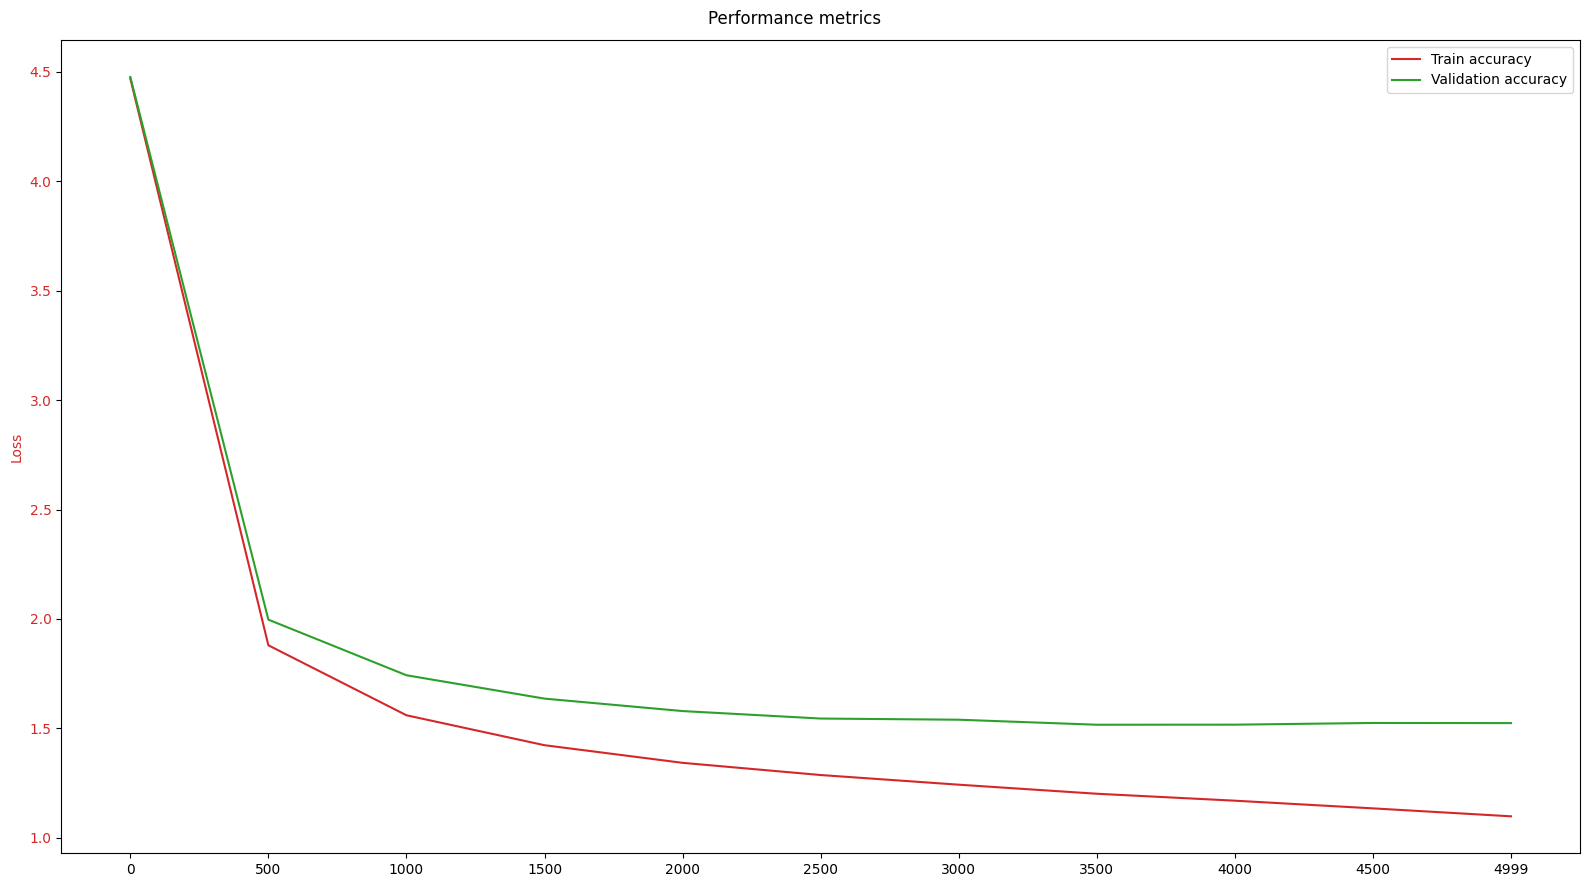

In [338]:
str_stamp = datetime.now().strftime('%Y%M%d_%H%M%S')
file_name = f'transformer_performance_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l_{str_stamp}.png'
generate_training_plots(train_loss_history, val_loss_history, iterations=epochs, file_name=file_name)

### Saving the model

In [339]:
str_stamp = datetime.now().strftime('%Y%M%d_%H%M%S')
file_name = f'transformer_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l_{str_stamp}.pth'
print(f'Saving {file_name}')
torch.save(model.state_dict(),file_name)

Saving transformer_64ba_256bl_384em_6he_4l_20253204_033242.pth


### Generation Function

Implement a `generate` function.

- Take a starting context (e.g., a single character).
   
- Pass through the model to get logits.
   
- Apply Softmax to get probabilities.
   
- Sample from the distribution (`torch.multinomial`).
   
- Append the new character and repeat.

In [340]:
# batch_size = 8
# block_size = 4
# n_embd = 64
# n_head = 4
# n_layer = 3

# batch_size = 32
# block_size = 128
# n_embd = 384
# n_head = 6
# n_layer = 4

batch_size = 64
block_size = 256
n_embd = 384
n_head = 6
n_layer = 4

search_directory = Path('./')

#file_name = f'transformer_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l.pth'
file_name_template = f'transformer_{batch_size}ba_{block_size}bl_{n_embd}em_{n_head}he_{n_layer}l*.pth'
file_list = list(search_directory.glob(file_name_template))
print(file_list)
file_name = file_list[-1]
print(file_name)

print('Creating Model ...')
model_pred = GPTLanguageModel()
model_pred.to(device)
model_pred.load_state_dict(torch.load(file_name))

[WindowsPath('transformer_64ba_256bl_384em_6he_4l_20253204_033242.pth')]
transformer_64ba_256bl_384em_6he_4l_20253204_033242.pth
Creating Model ...


<All keys matched successfully>

In [341]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model_pred.generate(context, max_new_tokens=500)[0].tolist()))


MENENIUS:
He hath Romeo? why, now doth stronge thinks thou hither?

MARCIUS:
O, whence minious bad! what said,
Freceiths borow agains more?

MOPSA:
I shall be gone.

AUTOLYBROLANUS:
What being so?

ANTIGONUS:
Then pass Katharice is strange, is this news?
The issued confircenks not a doubt, a dife
To tack our of his wife, all; call, take it.

POMPEY:
I am angrow honest his lead; he'll presumed within me,
I am forth there. Come hither, go.

Mayor: taure, sir, the king hast thou lietters; now
Acrus


### Analysis Questions (Include in Report)

1. **Scaling:** Why do we divide by $\sqrt{d_k}$ in the attention formula? What happens to the Softmax gradients if we don't?
   

2. **Positional Encoding:** Why do we add positional encodings to the embeddings rather than concatenating them?


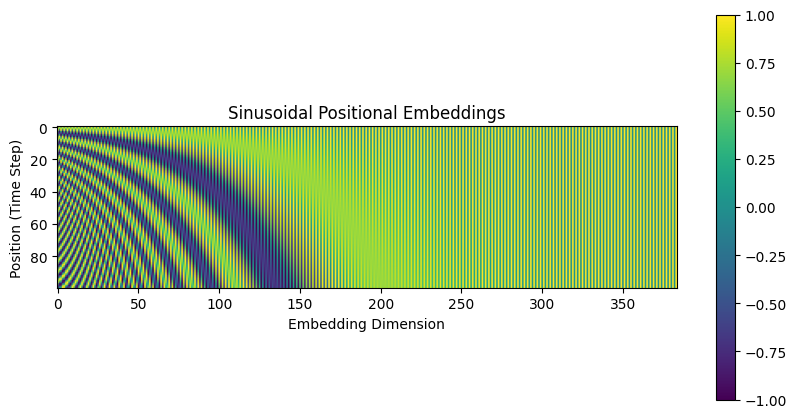

3. **Complexity:** What is the Big-O time complexity of the Self-Attention mechanism with respect to the sequence length $T$? Why is this a problem for very long texts?

## 6. Starter Code Snippet (Helper)

Here is the signature for your Multi-Head Attention to get you started:

Python

```
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embd, dropout=0.2):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size * num_heads, bias=False)
        self.query = nn.Linear(n_embd, head_size * num_heads, bias=False)
        self.value = nn.Linear(n_embd, head_size * num_heads, bias=False)
        # You need to register the mask as a buffer so it's not treated as a parameter
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
       
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # B: Batch, T: Time (Sequence Length), C: Channels (Embed size)
        B, T, C = x.shape
       
        # Implementation goes here...
        pass
```